In [1]:
pip install torch==2.2.1 torchvision==0.17.1 torchaudio==2.2.1 --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121Note: you may need to restart the kernel to use updated packages.

     ---------------------------------------- 0.0/5.7 MB ? eta -:--:--
     ----- ---------------------------------- 0.8/5.7 MB 17.4 MB/s eta 0:00:01
     ---------- ----------------------------- 1.5/5.7 MB 19.6 MB/s eta 0:00:01
     --------------- ------------------------ 2.3/5.7 MB 18.2 MB/s eta 0:00:01
     -------------------- ------------------- 3.0/5.7 MB 17.3 MB/s eta 0:00:01
     -------------------------- ------------- 3.7/5.7 MB 17.1 MB/s eta 0:00:01
     ------------------------------ --------- 4.4/5.7 MB 16.7 MB/s eta 0:00:01
     ----------------------------------- ---- 5.1/5.7 MB 16.2 MB/s eta 0:00:01
     ---------------------------------------  5.7/5.7 MB 16.7 MB/s eta 0:00:01
     ---------------------------------------- 5.7/5.7 MB 16.0 MB/s eta 0:00:00
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ---------------- 

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


### 해당 파일은 GPU성능이 좋은 컴퓨터로 실행해야오래걸리지 않음

In [1]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, checkpoint_path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.checkpoint_path = checkpoint_path
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.checkpoint_path)

# Custom Dataset 클래스 정의
class CustomImageDataset(Dataset):
    def __init__(self, directory, csv_file, transform=None):
        self.directory = directory
        self.transform = transform
        self.df = pd.read_csv(csv_file)
        self.df = self.df.dropna(subset=['Image name'])
        
        if 'Train' in directory:
            self.df = self.df[self.df['Usage'] =='Training']
        elif 'Valid' in directory:
            self.df = self.df[self.df['Usage'] == 'PublicTest']
        else: 
            self.df = self.df[self.df['Usage'] == 'PrivateTest']
        

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.df.iloc[idx]['Image name'])
        image = Image.open(img_name)
        label = self.df.iloc[idx][2:12].values.argmax()
        if self.transform:
            image = self.transform(image)
        return image, label
        
        
from torch.utils.data import ConcatDataset

# 이미지 전처리 정의
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 이미지를 그레이스케일로 변환
     transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5076], std=[0.2120]),  # 1채널 이미지에 맞게 조정
])

# 데이터셋과 데이터로더 생성
# test+valid
train_dataset = CustomImageDataset(directory='./data1/FER2013Train', csv_file='./fer2013new__.csv', transform=transform)
test1_dataset = CustomImageDataset(directory='./data1/FER2013Valid', csv_file='./fer2013new__.csv', transform=transform)
test2_dataset = CustomImageDataset(directory='./data1/FER2013Test', csv_file='./fer2013new__.csv', transform=transform)

test_dataset = ConcatDataset([test1_dataset, test2_dataset])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)



class myVGG19(nn.Module):
    def __init__(self):
        super(myVGG19, self).__init__()
        self.vgg19 = models.vgg19(pretrained=False)
        self.vgg19.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        num_ftrs = self.vgg19.classifier[6].in_features
        self.vgg19.classifier[6] = nn.Linear(num_ftrs, 10)
    
    def forward(self, x):
        return self.vgg19(x)

model = myVGG19().to('cuda' if  torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

early_stopper = EarlyStopping(patience=3, min_delta=0.01, checkpoint_path='./model_checkpoint.pt')

def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to('cuda' if torch.cuda.is_available() else 'cpu'), target.to('cuda' if torch.cuda.is_available() else 'cpu')
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item() * data.size(0)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    train_loss /= total
    accuracy = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(accuracy)
    print(f'Epoch: {epoch}, Training Loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}%')

def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to('cuda' if torch.cuda.is_available() else 'cpu'), target.to('cuda' if torch.cuda.is_available() else 'cpu')
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    test_loss /= total
    accuracy = 100. * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f"Test loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

for epoch in range(1, 16):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)
    
    early_stopper(test_losses[-1], model)
    if early_stopper.early_stop:
        print("Early stopping")
        break

model.load_state_dict(torch.load('./model_checkpoint.pt'))


C:\Users\songh\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\songh\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


KeyboardInterrupt: 

: 

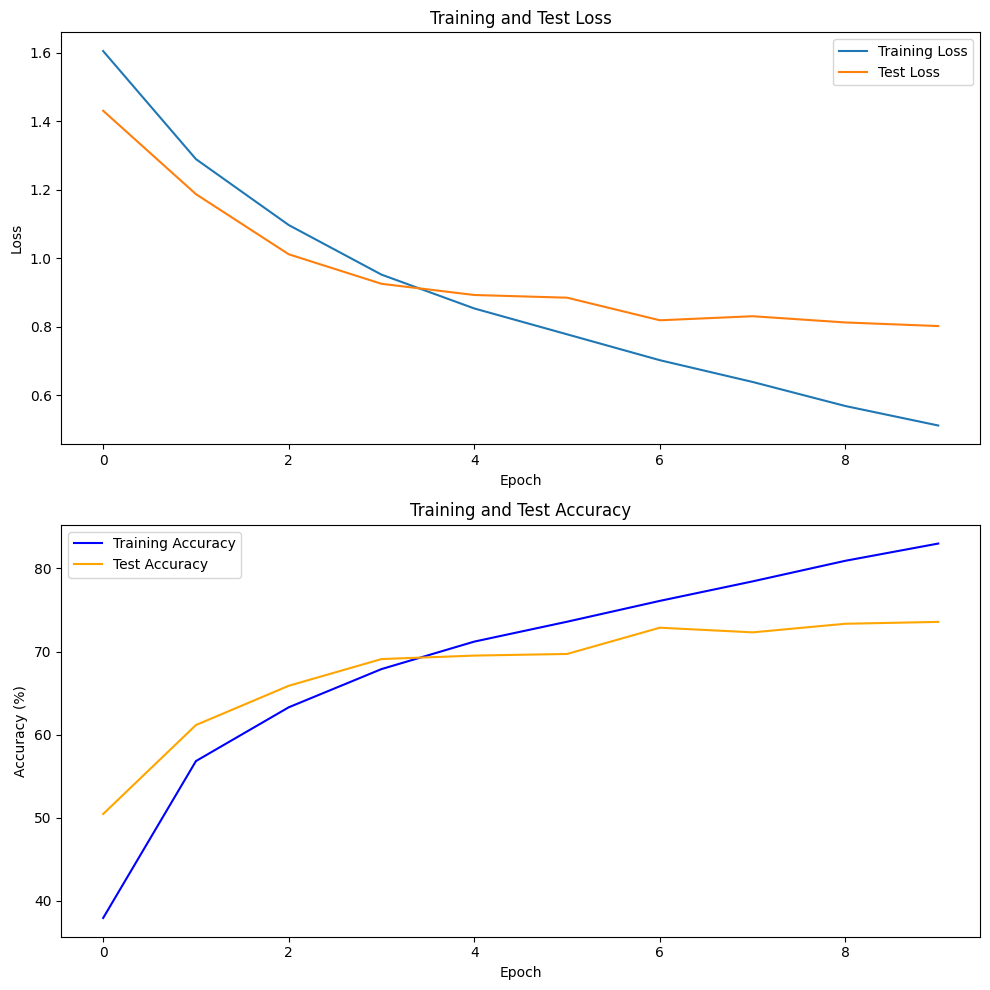

In [2]:
import matplotlib.pyplot as plt

# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accuracy')

plt.tight_layout()
plt.show()


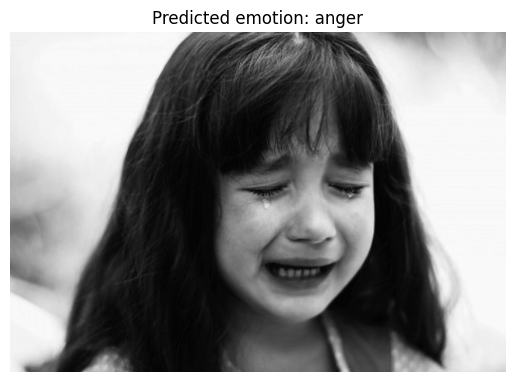

In [7]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import torch



# 사진 전처리를 위한 변환 정의
transform = transforms.Compose([
    transforms.Resize((48, 48)),  # 예제에서 사용하는 모델 입력 크기에 맞춰 조정
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5076], std=[0.2120]),
])

# 사진 불러오기 및 전처리
img_path = './TestImage/sad3.jpg'  # 분류하려는 사진의 경로
img = Image.open(img_path)
img_transformed = transform(img)
img_transformed = img_transformed.unsqueeze(0)  # 모델에 입력하기 위해 배치 차원 추가

# 모델을 평가 모드로 설정하고 사진 분류
model.eval()
with torch.no_grad():
    output = model(img_transformed.to('cuda' if torch.cuda.is_available() else 'cpu'))
    _, predicted = torch.max(output, 1)

import matplotlib.pyplot as plt

# 감정 레이블 정의 (컬럼 순서에 따라)
emotion_labels = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt', 'unknown', 'NF']

# 예측된 클래스 인덱스
predicted_class_index = predicted.item()

# 예측된 감정 레이블
predicted_label = emotion_labels[predicted_class_index]

# 이미지 표시
img = Image.open(img_path)
plt.imshow(img, cmap='gray')  # 그레이스케일 이미지인 경우 cmap='gray'를 사용
plt.title(f'Predicted emotion: {predicted_label}')
plt.axis('off')  # 축 표시 제거
plt.show()
